# Welcome to Jupyter!

This repo contains an introduction to [Jupyter](https://jupyter.org) and [IPython](https://ipython.org).

Outline of some basics:

* [Notebook Basics](../examples/Notebook/Notebook%20Basics.ipynb)
* [IPython - beyond plain python](../examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb)
* [Markdown Cells](../examples/Notebook/Working%20With%20Markdown%20Cells.ipynb)
* [Rich Display System](../examples/IPython%20Kernel/Rich%20Output.ipynb)
* [Custom Display logic](../examples/IPython%20Kernel/Custom%20Display%20Logic.ipynb)
* [Running a Secure Public Notebook Server](../examples/Notebook/Running%20the%20Notebook%20Server.ipynb#Securing-the-notebook-server)
* [How Jupyter works](../examples/Notebook/Multiple%20Languages%2C%20Frontends.ipynb) to run code in different languages.

You can also get this tutorial and run it on your laptop:

    git clone https://github.com/ipython/ipython-in-depth

Install IPython and Jupyter:

with [conda](https://www.anaconda.com/download):

    conda install ipython jupyter

with pip:

    # first, always upgrade pip!
    pip install --upgrade pip
    pip install --upgrade ipython jupyter

Start the notebook in the tutorial directory:

    cd ipython-in-depth
    jupyter notebook

In [6]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np

In [2]:

# Update value map based on reward entities input
def update_value_map(rval, value_map, world_dim, max_reward_spread=0, OUTER_MAP_VALUES=((-100, -100),(-100, -100))):
    '''
    Updates the reward value map with mask matrix application, based on reward entity.
    Returns a numpy array representing the updated reward value map.
    '''
    # Add map padding
    pad_dim = (world_dim[0]-1,world_dim[1]-1)
    value_map = np.pad(value_map, (pad_dim,pad_dim), 'constant', constant_values=OUTER_MAP_VALUES)
    rval_offset = pad_dim[0]

    reward = rval[2]
    reward_discount = reward/abs(reward)
    reward_spread=0
    
    # Max reward spread shall not exceed the dimension of the map
    # (mask matrices of +1 or -1 are applied in additive layers that correspond to the magnitude of the reward value)
    max_reward_spread = min(max_reward_spread, world_dim[0]-1)
    
    if reward > 0:
        # positive reward value
        for i, value in enumerate(range(0, reward, 1)):
            if i <= max_reward_spread:
                reward_spread = i
            xstart= rval[1] + rval_offset - reward_spread
            xend = rval[1] + rval_offset + 1 + reward_spread
            ystart = rval[0] + rval_offset - reward_spread
            yend = rval[0] + rval_offset + 1 + reward_spread

            # Updates reward values in the map matrix.
            value_map[xstart:xend,ystart:yend] = value_map[xstart:xend,ystart:yend] + reward_discount
            
    elif reward < 0:
        # negative reward value
        for i, value in enumerate(range(0, reward, -1)):
            if i <= max_reward_spread:
                reward_spread = i
            xstart= rval[1] + rval_offset - reward_spread
            xend = rval[1] + rval_offset + 1 + reward_spread
            ystart = rval[0] + rval_offset + 1 - reward_spread
            yend = rval[0] + rval_offset + 1 + reward_spread

            # Updates reward values in the map matrix.
            value_map[xstart:xend,ystart:yend] = value_map[xstart:xend,ystart:yend] + reward_discount
    else:
        # Reward assigned is 0.
        pass

    # Remove map padding
    value_map = value_map[world_dim[0]-1:world_dim[0]+pad_dim[0],world_dim[0]-1:world_dim[0]+pad_dim[0]]

    return value_map

In [3]:
def is_in_bounds(tile, world_width, world_height) -> bool:
    """
    Checks whether the tile is within the world boundaries
    """
    return (0 <= tile[0] < world_width) and (0 <= tile[1] < world_height)


In [4]:
def get_surrounding_tiles(location, world_width, world_height):
    """Given a tile location as an (x,y) tuple, this function will return the surrounding tiles up, down, left and to
    the right as a list (i.e. [(x1,y1), (x2,y2),...]) as long as they do not cross the edge of the map """
    x = location[0]
    y = location[1]

    # find all the surrounding tiles relative to us
    # location[0] = col index; location[1] = row index
    tile_up = (x, y - 1)
    tile_down = (x, y + 1)
    tile_left = (x - 1, y)
    tile_right = (x + 1, y)

    # combine these int a list
    all_surrounding_tiles = [tile_up, tile_down, tile_right, tile_left]

    # get ones that are within bounds
    valid_surrounding_tiles = []

    for tile in all_surrounding_tiles:
        if is_in_bounds(tile, world_width, world_height):
            valid_surrounding_tiles.append(tile)

    return valid_surrounding_tiles

In [5]:
def move_to_tile(location, tile):
    """
    Determines the action based on the tile. The other tile must be adjacent to the location tile
    """
    diff = tuple(x - y for x, y in zip(location, tile))

    if diff == (0, 1):
        return "down"
    elif diff == (1, 0):
        return "left"
    elif diff == (0, -1):
        return "up"
    elif diff == (-1, 0):
        return "right"
    else:
        return "none"

In [6]:
def get_move_from_value_map(cur_loc, value_map, world):
    world_width, world_height = world
    neighbours = get_surrounding_tiles(cur_loc, world_width, world_height)
    max_val = -1
    new_loc = cur_loc
    for tile in neighbours:
        x, y = tile
        tile_val = value_map[y, x]
#         print(tile, tile_val)
        if tile_val > max_val:
            max_val = tile_val
            new_loc = tile
            print('current location: ',cur_loc)
            print('new location: ', new_loc)
    return move_to_tile(cur_loc, new_loc)

In [7]:
def get_tile_scores_from_mask(tiles, mask):
    tile_scores = np.zeros(len(tiles))
    for i in range(len(tiles)):
        x, y = tiles[i]
        tile_scores[i] = mask[y, x]
    return tile_scores

In [8]:
def get_reward_mask(item, reward, world, is_tuple=False):
    """
    Returns reward mask
    """
    world_width, world_height = world
    mask = np.zeros((world_width, world_height))

    abs_reward = abs(reward)

    # modified iterative floodfill algorithm
    to_fill = set()
    if is_tuple:
        to_fill.add(item)
    else:
        to_fill.add(item['loc'])
    while len(to_fill) != 0:
        cur_tile = to_fill.pop()
        neighbours = get_surrounding_tiles(cur_tile, world_width, world_height)
        tile_scores = get_tile_scores_from_mask(neighbours, mask)
        max_reward = np.amax(tile_scores)
        cur_tile_x, cur_tile_y = cur_tile
        if max_reward == 0:  # evaluating starting point
            mask[cur_tile_y, cur_tile_x] = abs_reward
        else:
            mask[cur_tile_y, cur_tile_x] = max_reward - 1
        if max_reward != 1:
            for tile in neighbours:
                x, y = tile
                if mask[y, x] == 0:  # not visited
                    to_fill.add(tile)

    # propagation decreases or increases the value of reward by one until it reaches 0
    # if the reward is a negative number, it will add 1 for each level until reaches 0
    # the opposite is applied to positive numbers
    return mask * -1 if reward < 0 else mask

In [9]:
world_dim = (9,9)
max_reward_spread=world_dim[0]-1
will_map=np.zeros(world_dim)
chris_map=np.zeros(world_dim)
world_map = np.zeros(world_dim)
entities = [
    [5,5,5],
    [3,3,2]
]

for entity in entities:
    entity_x, entity_y, reward = entity
    world_map[entity_y, entity_x] = reward
    reward_mask = get_reward_mask((entity_x, entity_y), reward, world_dim, True)
    will_map = update_value_map(entity, will_map, world_dim, max_reward_spread)
    chris_map = np.add(chris_map, reward_mask)
    

In [10]:
will_map

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 3., 3., 3., 2., 2., 2., 2.],
       [0., 1., 3., 5., 4., 3., 3., 3., 2.],
       [0., 1., 3., 4., 5., 4., 4., 3., 2.],
       [0., 1., 2., 3., 4., 5., 4., 3., 2.],
       [0., 1., 2., 3., 4., 4., 4., 3., 2.],
       [0., 1., 2., 3., 3., 3., 3., 3., 2.],
       [0., 1., 2., 2., 2., 2., 2., 2., 2.]])

In [11]:
player_loc = (3,5)
print("Player is at", player_loc)

Player is at (3, 5)


In [12]:
get_move_from_value_map(player_loc, will_map, world_dim)
# printing out surrounding tiles and their value states

current location:  (3, 5)
new location:  (3, 4)


'down'

In [40]:
world_dim = (9,9)
max_reward_spread=world_dim[0]-1
will_map=np.zeros(world_dim)
chris_map=np.zeros(world_dim)
world_map = np.zeros(world_dim)
entities = [
    [5,5,5],
    [3,3,2],
    [3,7,7],
    [4,8,-2],
    [2,2,-5],
    [1,1,3],
    [8,7,9]
]

for entity in entities:
    entity_x, entity_y, reward = entity
    world_map[entity_y, entity_x] = reward
    reward_mask = get_reward_mask((entity_x, entity_y), reward, world_dim, True)
    will_map = update_value_map(entity, will_map, world_dim, max_reward_spread)
    chris_map = np.add(chris_map, reward_mask)

    
print("Entities")
print(entities)

print("New reward map")
print(will_map)

print("Old reward map")
print(chris_map)

# player_loc = (3,5)
print("Player is at", player_loc)

chris_next_move = get_move_from_value_map(player_loc, chris_map, world_dim)
will_next_move = get_move_from_value_map(player_loc, will_map, world_dim)

world_map[player_loc[1], player_loc[0]] = -2

print("Next move using new map:", will_next_move)
print("Next move old map:", chris_next_move)

print(world_map)

Entities
[[5, 5, 5], [3, 3, 2], [3, 7, 7], [4, 8, -2], [2, 2, -5], [1, 1, 3], [8, 7, 9]]
New reward map
[[ 1.  1.  1.  0. -1.  0.  1.  2.  2.]
 [ 2.  4.  3.  2.  2.  3.  4.  5.  5.]
 [ 3.  4.  6.  6.  6.  6.  7.  8.  8.]
 [ 3.  4.  6.  9.  9.  9. 10. 11.  9.]
 [ 3.  4.  7.  9. 11. 12. 13. 12. 10.]
 [ 3.  6.  8. 10. 12. 14. 14. 13. 11.]
 [ 4.  7. 10. 12. 14. 14. 14. 14. 12.]
 [ 5.  8. 11. 14. 13. 13. 14. 14. 13.]
 [ 5.  8. 11. 12. 12. 12. 13. 13. 12.]]
Old reward map
[[ 0.  0. -2. -2. -1.  0.  0.  1.  2.]
 [ 0.  0. -2. -1. -2.  0.  1.  2.  3.]
 [-2. -2. -3. -1. -1.  1.  2.  3.  4.]
 [-2. -1. -1.  3.  4.  5.  5.  5.  5.]
 [ 0.  0.  1.  6.  7.  9.  8.  7.  7.]
 [ 2.  3.  5.  9. 11. 12. 11. 10.  9.]
 [ 3.  5.  7. 11. 12. 13. 12. 11. 10.]
 [ 5.  7.  9. 12. 12. 14. 13. 12. 11.]
 [ 3.  5.  7.  8.  8. 10. 10.  9.  9.]]
Player is at (3, 5)
current location:  (3, 5)
new location:  (3, 4)
current location:  (3, 5)
new location:  (3, 6)
current location:  (3, 5)
new location:  (3, 4)
current locat

In [41]:
import matplotlib.pyplot as plt # visualisation
import seaborn as sns # visualisation

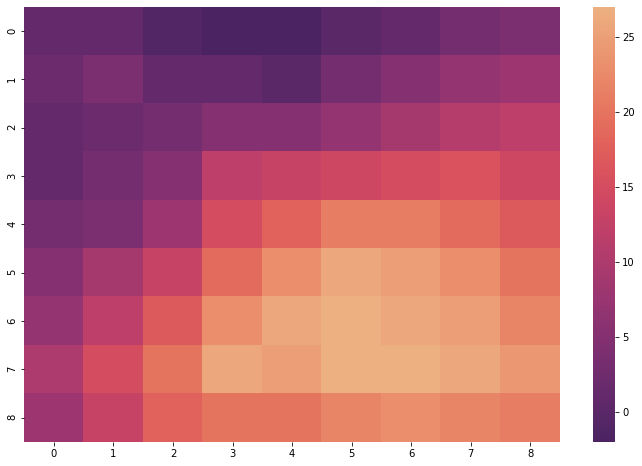

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.add(will_map, chris_map), cmap='flare_r')

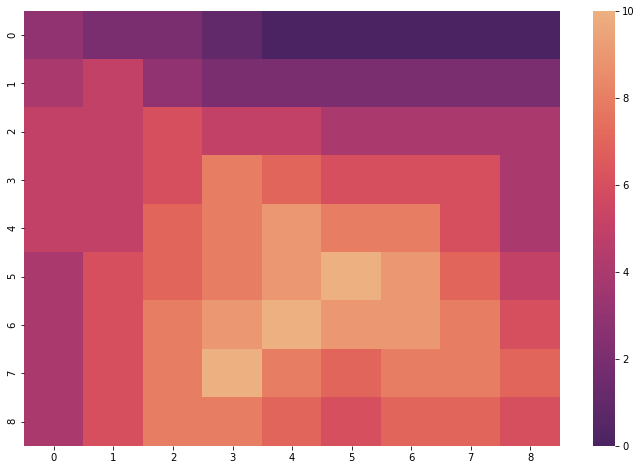

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(will_map, cmap='flare_r')

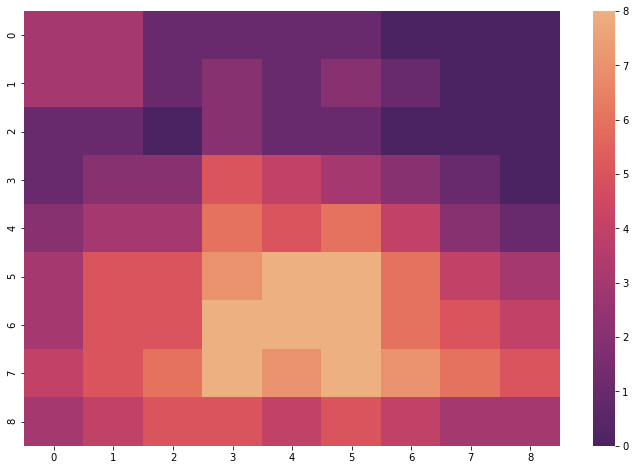

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(chris_map, cmap='flare_r')

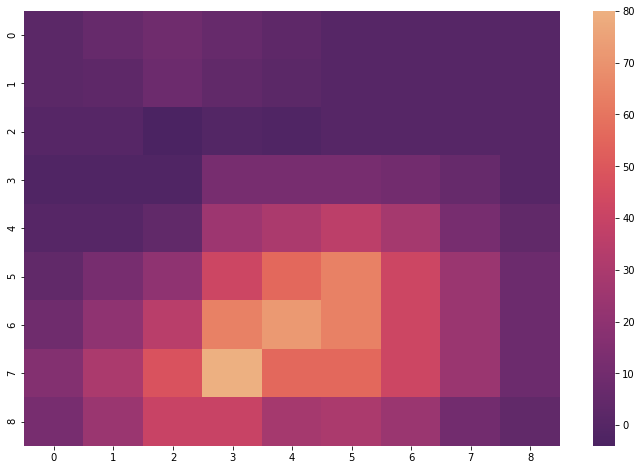

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.multiply(will_map, chris_map), cmap='flare_r')

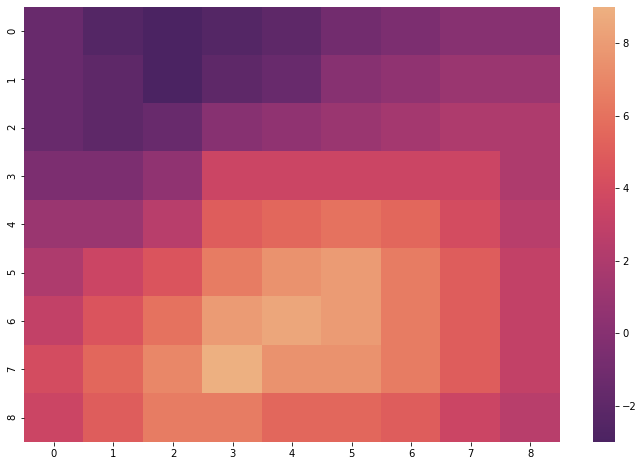

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.add(np.multiply(will_map,0.5), np.multiply(chris_map, 0.5)), cmap='flare_r')

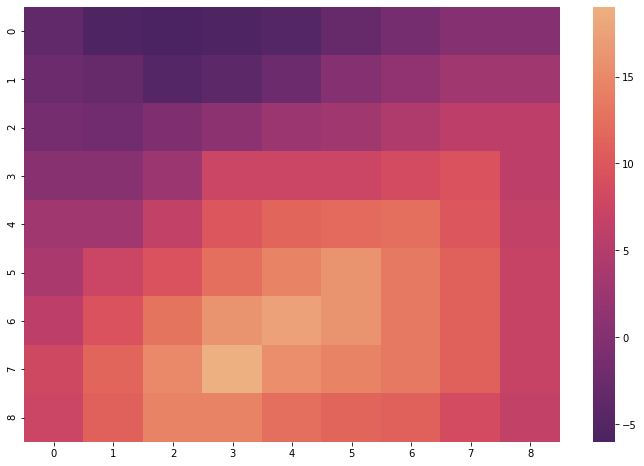

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.add(np.multiply(will_map,1.5), np.multiply(chris_map, 0.5)), cmap='flare_r')

In [93]:
player_loc = (3, 6)
next_move = get_move_from_value_map(player_loc, np.add(will_map,chris_map), world_dim)
print('Player location: ', player_loc)
print("Next move using new map:", next_move)

current location:  (3, 6)
new location:  (3, 5)
current location:  (3, 6)
new location:  (3, 7)
Player location:  (3, 6)
Next move using new map: up


In [87]:
np.add(will_map,chris_map)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  2.,  2.,  3.,  2.,  3.,  2.,  2.,  2.],
       [ 2.,  3.,  6.,  8.,  7.,  6.,  5.,  4.,  4.],
       [ 3.,  5.,  9., 14., 12., 10.,  8.,  7.,  4.],
       [ 5.,  7., 11., 15., 15., 14., 12.,  8.,  5.],
       [ 6., 10., 13., 16., 17., 18., 14., 10.,  6.],
       [ 7., 10., 14., 17., 18., 17., 14., 10.,  6.],
       [ 8., 11., 14., 18., 17., 16., 13., 10.,  6.],
       [ 7., 10., 13., 14., 14., 13., 10.,  7.,  5.]])

In [ ]:
a = 1

b = a
c = a

c